In [1]:
import subprocess
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import json
from astropy.time import Time
from scipy.optimize import curve_fit
import yaml

In [2]:
spectra = np.random.rand(100, 1, 1000)  # 示例数据

In [3]:
# SN2011fe_110906=SN2011fe_sne.spec_id(10,plot=True)
# SN2011fe_110906=SN2011fe_sne.spec_save()

In [4]:
import yaml
def spec_interp_wv(spec,yaml_name):
    synpp_param=yaml.safe_load(open(yaml_name,"r"))['output']
    synpp_wl =np.arange(synpp_param['min_wl'],
                        synpp_param['max_wl']+1e-5,
                        synpp_param['wl_step'],)
    flux_intp=np.interp(synpp_wl,spec[:,0],spec[:,1])
    spec_interp=np.concatenate((synpp_wl.reshape(-1,1),
                              flux_intp.reshape(-1,1)),
                              axis=1)
    return spec_interp,[max(min(spec[:,0]),synpp_param['min_wl']),
                        min(max(spec[:,0]),synpp_param['max_wl'])]
def invoke_synpp(yaml_name):
    cmd=["syn++",yaml_name]
    result = subprocess.run(cmd, stdout=subprocess.PIPE)  
    synpp_result=np.float32([i.split() for i in result.stdout.decode().split("\n")[:-2]])
    return synpp_result

    # print(type(synpp_result))
    # print(np.array([i.split() for i in result.stdout.decode().split("\n")]))# chi2=

def spec_check_flux_err(spec,error_scale=10):
    if spec.shape[1]==1:raise(IndexError(""))
    elif spec.shape[1]==2:
        Warning("Add flux error")
        return np.concatenate((spec, spec[:,1].reshape(-1,1)/error_scale), axis=1)
    elif spec.shape[1]>3:
        return spec[:,:3]
from scipy.optimize import curve_fit
def calculate_chi2(spec_data,synpp_result,spec_range):
    synpp_result_arg=np.where(((synpp_result[:,0]>spec_range[0]) & (synpp_result[:,0]<spec_range[1])))
    spec_synpp=synpp_result[synpp_result_arg]
    spec_data =spec_data   [synpp_result_arg]
    def flux_scale(spec_flux,scale,shift):
        return spec_flux*scale+shift
    param,pcov=curve_fit(f=flux_scale,
                         xdata=spec_data[:,1],
                         ydata=spec_synpp[:,1],
                         p0=[1.1,0.1])
    f_scale,f_shift=tuple(param)
    spec_data[:,1:3]=spec_data[:,1:3]*f_scale+f_shift
    chi2=np.sum(((spec_data[:,1]-spec_synpp[:,1])/spec_data[:,2])**2)
    plt.plot(spec_data[:,0],spec_data[:,1])
    plt.plot(spec_synpp[:,0],spec_synpp[:,1])
    return chi2

def spec_norm(spec,order=3):
    wv   = spec[:,0]
    flux = spec[:,1]
    def poly(x,*arg):
        y=np.poly1d(arg)
        return y(x)
    param,pcov=curve_fit(poly,xdata=wv,ydata=flux,p0=[1]*order)
    flux_ploy=poly(wv,*param)
    scale=2*np.nanmedian(flux_ploy)
    spec[:,1]=flux/scale
    return spec
# spec_data=spec_norm(spec_data)


In [5]:

# data_name="SN2011fe_20110829_Gemini_N_GMOS.dat"
# # yaml_name="SN2011fe_110906_syn++.0000.tmp.bb.yaml"
# yaml_name="SN2011fe_110906_syn++.0000.tmp.yaml"
# param_synpp=yaml.safe_load(open(yaml_name,"r"))

# spec_data=np.loadtxt(data_name)
# spec_data,spec_range=spec_interp_wv(spec_data,yaml_name)
# spec_data=spec_check_flux_err(spec_data)
# spec_data=spec_norm(spec_data)
# synpp_result=invoke_synpp(yaml_name)
# calculate_chi2(spec_data,synpp_result,spec_range)


In [6]:
# spec_base="SN2020adow_syn++"
# zfill=4
# N_sample=4000

In [7]:
# from Synpp import Synpp
# import copy
# os.chdir("/home/ysy/_data/source/2020adow/spec/synpp/")
# new_yaml_all_path="./new_yaml_all"
# new_yaml_all_path="./new_yaml_all_2"
# new_yaml_all_path="./new_yaml_all_3"
# if not os.path.exists(new_yaml_all_path):os.mkdir(new_yaml_all_path)



# yaml_file=spec_base+"."+"0".zfill(zfill)+".yaml"
# Synpp_yaml    =yaml.load(open(yaml_file,"r"),Loader=yaml.CLoader)

# os.chdir(new_yaml_all_path)



In [8]:

# uniform_params(size=0,bounds=param_bounds)

In [9]:
from Synpp import Synpp
import copy
class synpp_yaml():
    def __init__(self,yaml_name,
                 fix_a0=True,fix_a1=True,fix_a2=True,
                 fix_vphot=False,
                 fix_tphot=False,
                 fix_v_max=True,
                 ):
        import yaml
        Synpp_yaml =yaml.load(open(yaml_name,"r"),Loader=yaml.CLoader)
        ion_arg=np.where(Synpp_yaml["setups"][0]['active'])
        ion_num=len(ion_arg[0])
        
        self.ion_num=ion_num
        self.ion_arg=ion_arg
        self.synpp_yaml=Synpp_yaml
        self.yaml_name=os.path.basename(yaml_name)
        self.yaml_base=os.path.splitext(self.yaml_name)[0]
        self.fix_a0=fix_a0
        self.fix_a1=fix_a1
        self.fix_a2=fix_a2
        self.fix_vphot=fix_vphot
        self.fix_tphot=fix_tphot
        self.fix_v_max=fix_v_max
        self.obs_spec=None
        self.synpp_wv=np.arange(self.synpp_yaml["output"]["min_wl"],
                                self.synpp_yaml["output"]["max_wl"]+1e-5,
                                self.synpp_yaml["output"]["wl_step"],
                                )
        self.periodioc_table=['H', 'He', 
            'Li', 'Be',  'B',  'C',  'N',  'O',  'F', 'Ne', 'Na', 'Mg', 'Al', 'Si',  'P',  'S', 'Cl', 'Ar',
            'K', 'Ca', 'Sc', 'Ti',  'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 
            'Kr', 'Rb', 'Sr',  'Y', 'Zr', 'Nb', 'Mo', 'Te', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 
            'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 
            'Yb', 'Lu', 'Hf', 'Ta',  'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 
            'Fr', 'Ra', 'Ac', 'Th', 'Pa',  'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr',
            'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og', 'Uue'
        ]
    def generate_bounds(self):
        self.a0_range=(0.01,1)
        self.a1_range=(0.01,1)
        self.a2_range=(-1, 1)
        self.v_phot_range=(5,15)
        self.t_phot_range=(5,30)
        
        self.log_tau_range=(-2  ,3)
        self.v_min_range  =(1   ,15)
        self.v_max_range  =(15  ,30)
        self.aux_range    =(1   ,10)
        self.temp_range   =(1   ,20)
        param_bounds = []
        if not self.fix_a0   :param_bounds += [self.a0_range]
        if not self.fix_a1   :param_bounds += [self.a1_range]
        if not self.fix_a2   :param_bounds += [self.a2_range]
        if not self.fix_vphot:param_bounds += [self.v_phot_range]
        if not self.fix_tphot:param_bounds += [self.t_phot_range]
        if not self.fix_v_max:param_bounds += [self.v_max_range]*self.ion_num

        param_bounds += [self.log_tau_range]*self.ion_num
        param_bounds += [self.v_min_range  ]*self.ion_num
        param_bounds += [self.aux_range    ]*self.ion_num
        param_bounds += [self.temp_range   ]*self.ion_num


        self.param_bounds=param_bounds
        return param_bounds
        # param_bounds = [(-5, 5), (-10, 3), (0, 1)]  # 每个元组代表一个参数的(min, max)

    # 定义参数生成函数
    def uniform_params(size, bounds):
        """根据给定的范围生成均匀分布的参数值列表"""
        return [np.random.uniform(low, high) for low, high in bounds]
    

    def creat_new_yaml(self,new_yaml_name,New_syapp_dict):
        from Synpp import Synpp
        with open(new_yaml_name,"w") as f:
            print (Synpp.create(New_syapp_dict),file=f)
    def invoke_synpp(self,yaml_name):
        cmd=["syn++",yaml_name]
        result = subprocess.run(cmd, stdout=subprocess.PIPE)  
        
        if result.stdout.decode()=='':
            synpp_result=np.zeros((len(self.synpp_wv),3))
            synpp_result[:,0]=self.synpp_wv
            synpp_result[3,1]+=0.01
        else:
            synpp_result=np.float32([i.split() for i in result.stdout.decode().split("\n")[:-2]])

        synpp_result[np.isnan(synpp_result[:,1]),1]=1e-5
        synpp_result[ np.inf==synpp_result[:,1] ,1]=1e5
        synpp_result[-np.inf==synpp_result[:,1] ,1]=1e-5
        return synpp_result
    # new_yaml_name=spec_base+"."+str(syn_id).zfill(zfill)+".yaml"
    def invoke_synpp_param(self,param_synpp):
        new_yaml_name=self.yaml_base+".tmp.yaml"
        self.param_creat_new_yaml(param_synpp,new_yaml_name)
        synpp_result=self.invoke_synpp(new_yaml_name)
        
        # print (synpp_result)
        return synpp_result
    
    def resample_observed_spec(self,obs_spec):
        # synpp_param=yaml.safe_load(open(yaml_name,"r"))['output']
        synpp_wl =self.synpp_wv
        flux_intp=np.interp(synpp_wl,obs_spec[:,0],obs_spec[:,1])
        spec_interp=np.concatenate((synpp_wl.reshape(-1,1),
                                    flux_intp.reshape(-1,1)),
                                    axis=1)
        self.obs_spec=obs_spec
        self.spec_interp=spec_interp
        return spec_interp,[max(min(obs_spec[:,0]),self.synpp_yaml['output']['min_wl']),
                            min(max(obs_spec[:,0]),self.synpp_yaml['output']['max_wl'])]
    def spec_match_template_scale_offset(self,flux,a,b):
        return a*flux+b
    def spec_match_template(self,syn_spec,obs_spec):
        if obs_spec.shape[0]!=syn_spec.shape[0]:
            obs_spec,_=self.resample_observed_spec(obs_spec)
        scale,_=curve_fit(f=self.spec_match_template_scale_offset,
                        xdata=syn_spec[:,1],
                        ydata=obs_spec[:,1],method="lm")
        return scale
    def plot_synpp_result(self,synpp_param,obs_spec=None):
        if obs_spec is None:
            obs_spec=self.obs_spec
        syn_spec=self.invoke_synpp_param(synpp_param)
        scale=self.spec_match_template(syn_spec,obs_spec)
        plt.plot(syn_spec[:,0],syn_spec[:,1]*scale[0]+scale[1],label="SYN++",color="k")
        if obs_spec is not None:
            plt.plot(obs_spec[:,0],obs_spec[:,1],label="Observed spectrum",color="r") 
        plt.legend()
    def int_to_roman(self,num):
        val = [
            1000, 900, 500, 400,
            100, 90, 50, 40,
            10, 9, 5, 4,
            1
        ]
        syms = [
            "M", "CM", "D", "CD",
            "C", "XC", "L", "XL",
            "X", "IX", "V", "IV",
            "I"
        ]
        roman_num = ''
        i = 0
        while num > 0:
            for _ in range(num // val[i]):
                roman_num += syms[i]
                num -= val[i]
            i += 1
        return roman_num
    @property
    def param_type(self):
        _param_type=[[],[],[]]
        
        if not self.fix_a0   :_param_type[0] += ["a0"]   ;_param_type[1] += ["a0"]   ;_param_type[2] += ["photosphere"]
        if not self.fix_a1   :_param_type[0] += ["a1"]   ;_param_type[1] += ["a1"]   ;_param_type[2] += ["photosphere"]
        if not self.fix_a2   :_param_type[0] += ["a2"]   ;_param_type[1] += ["a2"]   ;_param_type[2] += ["photosphere"]
        if not self.fix_vphot:_param_type[0] += ["vphot"];_param_type[1] += ["vphot"];_param_type[2] += ["photosphere"]
        if not self.fix_tphot:_param_type[0] += ["tphot"];_param_type[1] += ["tphot"];_param_type[2] += ["photosphere"]
        if not self.fix_v_max:_param_type[0] += ["v_max"]*self.ion_num;               _param_type[2] += ["ion"]*self.ion_num;_param_type[1] += list(np.array(self.synpp_yaml["setups"][0]["ions"])[self.ion_arg])

        _param_type[0] += ["log_tau"]*self.ion_num
        _param_type[0] += ["v_min"  ]*self.ion_num
        _param_type[0] += ["aux"    ]*self.ion_num
        _param_type[0] += ["temp"   ]*self.ion_num

        _param_type[1] += (list(np.array(self.synpp_yaml["setups"][0]["ions"])[self.ion_arg]))*4
        _param_type[2] += ["ion"]*(4*self.ion_num)

        return np.array(_param_type)
    def split_ions(self,flatten=False):
        import os 
        import yaml
        import numpy as np
        import matplotlib.pyplot as plt
        import copy
        import sys
        # from pyES.Synpp import Synpp
        from Synpp import Synpp
        ions_all     = np.array(self.synpp_yaml["setups"][0]["ions"],dtype=int)
        activate_all = np.array(self.synpp_yaml["setups"][0]["active"])
        

        self.Ion_name_all={"ES":self.yaml_name}

        for  i in self.ion_arg[0]:
            Activate=[False]*len(ions_all)
            Activate[i]=True

            New_syapp_yaml=copy.deepcopy(self.synpp_yaml)
            New_syapp_yaml["setups"][0]["active"]=Activate
            New_syapp_yaml["spectrum"]['flatten']=flatten

            ion_id=str(ions_all[i])

            ion_name =self.periodioc_table[int(ion_id[:-2])-1] +"_"+ self.int_to_roman((int(ion_id[-2:])+1))

            Ion_yaml_name=self.yaml_base+"."+ion_id+".yaml"

            self.creat_new_yaml(Ion_yaml_name,New_syapp_yaml,)

            self.Ion_name_all[ion_name]=Ion_yaml_name


        New_syapp_yaml=copy.deepcopy(self.synpp_yaml)
        New_syapp_yaml["setups"][0]["active"]=[False]*self.ion_num
        New_syapp_yaml["spectrum"]['flatten']=flatten
        BB_yaml_name=self.yaml_base+".BB.yaml"
        # BB_data_name=self.spec_base+".BB.dat"

        self.creat_new_yaml(BB_yaml_name,New_syapp_yaml,)
        self.Ion_name_all["BB"]=BB_yaml_name

        return self.Ion_name_all



    def plot_synpp_ions(self,spec_name,redshift=0.00,scale=[],flatten=False,figsize=(7,14),lw=1,delete_yaml=True):
        import os 
        import numpy as np
        import matplotlib.pyplot as plt

        self.split_ions(flatten=flatten)
        self.Ion_spec_data_all={}

        for  i in self.Ion_name_all:
            self.Ion_spec_data_all[i]=self.invoke_synpp(self.Ion_name_all[i])
            if delete_yaml and i!="ES" :
                if os.path.exists(self.Ion_name_all[i]):os.remove(self.Ion_name_all[i])
            print(f"{i} Done.")

        spec_data=np.loadtxt(spec_name)
        spec_data[:,0]=spec_data[:,0]/(1+redshift)
        if not any(scale):
            spec_resample,_=self.resample_observed_spec(obs_spec=spec_data)
            scale=self.spec_match_template(self.Ion_spec_data_all["ES"],
                                        obs_spec=spec_resample)

        plt.figure(figsize=figsize)


        offset1=0
        offset=0
        BBSpecData=self.Ion_spec_data_all["BB"]
        for i in self.Ion_spec_data_all:
            if i =="BB":continue
            ion_spec_data= self.Ion_spec_data_all[i]
            
            flux=ion_spec_data[:,1]
            wv  =ion_spec_data[:,0]
            offset2=np.min(flux-BBSpecData[:,1])
            offset =offset1-offset2+offset
            plt.plot(wv,flux+offset,"k",lw=1)
            plt.text(x=self.synpp_yaml["output"]["max_wl"]+200,
                    y=flux[-2]+offset,
                    s=i.replace("_"," "),
                    color="k")
            if i=="ES":
                plt.plot(spec_data[:,0],
                         (spec_data[:,1]-scale[1])/scale[0]+offset,
                        "r",lw=lw)
            offset1=np.max(flux-BBSpecData[:,1])
        plt.xlabel("Rest frame Wavelength")
    def complete_param(self,Params):
        
        i=0
        params=[]
        if self.fix_a0:    params.append(self.synpp_yaml["setups"][0]["a0"]) 
        else:              params.append(Params[i]);i+=1
        if self.fix_a1:    params.append(self.synpp_yaml["setups"][0]["a1"]) 
        else:              params.append(Params[i]);i+=1
        if self.fix_a2:    params.append(self.synpp_yaml["setups"][0]["a2"]) 
        else:              params.append(Params[i]);i+=1
        if self.fix_vphot: params.append(self.synpp_yaml["setups"][0]["v_phot"]) 
        else:              params.append(Params[i]);i+=1
        if self.fix_tphot: params.append(self.synpp_yaml["setups"][0]["t_phot"]) 
        else:              params.append(Params[i]);i+=1
        if self.fix_v_max: params=params+self.synpp_yaml["setups"][0]["v_max"] 
        else:              params=params+Params[i:i+self.ion_num];i+=self.ion_num

        params += Params[i:]
        return params
    
    def param_creat_new_yaml(self,params,new_yaml_name):

        params=self.complete_param(params)
        New_syapp_yaml=copy.deepcopy(self.synpp_yaml)
        # print(params)

        New_syapp_yaml["setups"][0]["a0"]    =params[0]
        New_syapp_yaml["setups"][0]["a1"]    =params[1]
        New_syapp_yaml["setups"][0]["a2"]    =params[2]
        New_syapp_yaml["setups"][0]["v_phot"]=params[3]
        New_syapp_yaml["setups"][0]["t_phot"]=params[4]

        log_tau_tmp=np.array(New_syapp_yaml["setups"][0]["log_tau"])
        v_min_tmp  =np.array(New_syapp_yaml["setups"][0]["v_min"])
        v_max_tmp  =np.array(New_syapp_yaml["setups"][0]["v_max"])
        aux_tmp    =np.array(New_syapp_yaml["setups"][0]["aux"])
        temp_tmp   =np.array(New_syapp_yaml["setups"][0]["temp"])

        ion_params =np.array(params[5:]).reshape(5,int(len(params[5:])/5))
        # print(params[5:])
        # print(ion_params)
        log_tau_tmp[self.ion_arg]=ion_params[1]
        v_min_tmp  [self.ion_arg]=ion_params[2]
        v_max_tmp  [self.ion_arg]=ion_params[0]
        aux_tmp    [self.ion_arg]=ion_params[3]
        temp_tmp   [self.ion_arg]=ion_params[4]

        New_syapp_yaml["setups"][0]["aux"]    =list(aux_tmp)
        New_syapp_yaml["setups"][0]["log_tau"]=list(log_tau_tmp)
        New_syapp_yaml["setups"][0]["v_min"]  =list(v_min_tmp)
        New_syapp_yaml["setups"][0]["v_max"]  =list(v_max_tmp)
        New_syapp_yaml["setups"][0]["temp"]   =list(temp_tmp)
        # print(New_syapp_yaml)
        self.creat_new_yaml(new_yaml_name,New_syapp_yaml)


# best_yaml="SN2020adow_syn++.0001tmp.best.yaml"
# synpp_.creat_new_yaml(best_ind,best_yaml)
# best_spec=synpp_.invoke_synpp(best_yaml)



# chi2_all=np.array([])

    
# synpp_=synpp_yaml("SN2020adow_syn++.0001.yaml")
synpp_=synpp_yaml("SN2014C_140108_syn++.yaml",fix_v_max=False)
synpp_=synpp_yaml("SN2014C_140118_NoSi_syn++.yaml",fix_v_max=False)
# synpp_.creat_new_yaml(synpp_.uniform_params(synpp_.generate_bounds()),
#                       "SN2020adow_syn++.tmp.yaml")
# synpp_.invoke_synpp_param(synpp_.uniform_params(synpp_.generate_bounds()))
# plt.plot(spec)
# synpp_.plot_synpp_ions("/home/ysy/_data/source/2020adow/spec/spectra/TEXT/sn2020adow-20210113.320.coadd.blotch-ui.dat")
def uniform_params( bounds):
    """根据给定的范围生成均匀分布的参数值列表"""

    return [np.random.uniform(low, high) for low, high in bounds]
synpp_.param_creat_new_yaml(uniform_params(synpp_.generate_bounds()),"SNtest.yaml",)

In [10]:

# synpp_yaml("test.yaml").plot_synpp_ions("/home/ysy/_data/source/2020adow/spec/spectra/TEXT/sn2020adow-20210113.320.coadd.blotch-ui.dat",
#                                                redshift=0.007505,
#                                              figsize=(5,4)
#                                                )

# synpp_yaml("test2.yaml").plot_synpp_ions("/home/ysy/_data/source/2020adow/spec/spectra/TEXT/sn2020adow-20210113.320.coadd.blotch-ui.dat",
#                                                redshift=0.007505,
#                                              figsize=(5,4)
#                                                )
# from astropy.constants import h, c, k_B
# import astropy.units as u
# def blackbody_radiation(T, wavelength):
#    	# 黑体辐射公式
# 	# print(T,wavelength)
# 	I = (2 * h * c**2 / wavelength**5) / (np.exp((h * c) / (wavelength * k_B * T)) - 1)

# 	return I.to(u.erg / (u.cm**2 * u.s * u.AA ))/u.sr
# # wv=np.linspace(2000,10000)
# # plt.plot(wv,blackbody_radiation(8.3e3*u.K,wv*u.AA)*1e-7,)

In [11]:
# aaaaaaaaaaaaaaaaaaaaaaaaaaaa

  0%|          | 0/50 [00:00<?, ?generation/s]

Generation 1, Best fitness: -1.7207151362081476


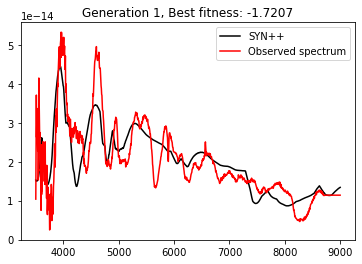

  2%|▏         | 1/50 [11:35<9:28:19, 695.91s/generation]

Generation 2, Best fitness: -1.8423346160752971


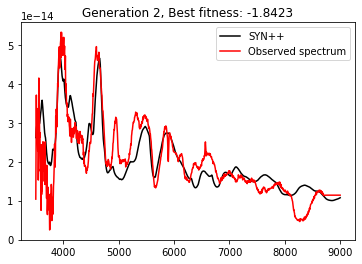

  4%|▍         | 2/50 [21:35<8:31:31, 639.40s/generation]

Generation 3, Best fitness: -2.0199580475932724


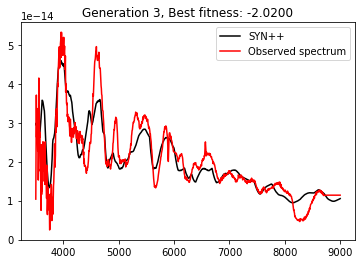

  6%|▌         | 3/50 [31:09<7:57:26, 609.51s/generation]

Generation 4, Best fitness: -2.348082363099507


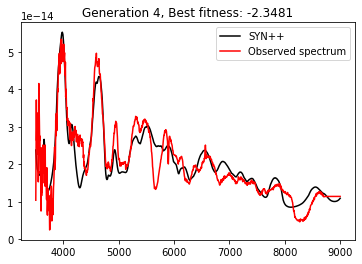

  8%|▊         | 4/50 [40:17<7:28:28, 584.96s/generation]

Generation 5, Best fitness: -2.396069797187435


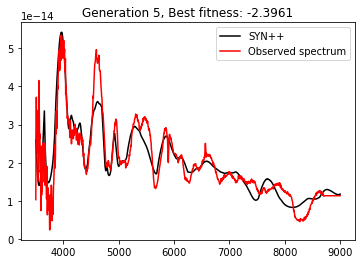

 10%|█         | 5/50 [48:42<6:57:09, 556.21s/generation]

Generation 6, Best fitness: -2.396069797187435


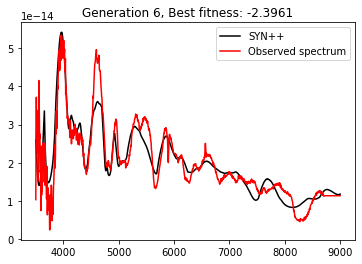

 12%|█▏        | 6/50 [56:21<6:23:38, 523.16s/generation]

mutation probability improved: mutpb=0.4
individual probability improved: indpb=0.4
crossover probability decrease: indpb=0.6
Generation 7, Best fitness: -2.484777691045169


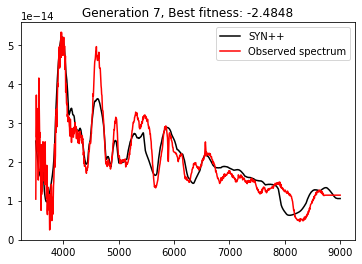

 14%|█▍        | 7/50 [1:05:23<6:19:23, 529.37s/generation]

Generation 8, Best fitness: -2.484777691045169


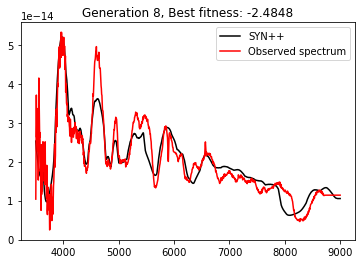

 16%|█▌        | 8/50 [1:16:55<6:46:52, 581.25s/generation]

mutation probability improved: mutpb=0.4
individual probability improved: indpb=0.4
crossover probability decrease: indpb=0.6
Generation 9, Best fitness: -2.561819997832355


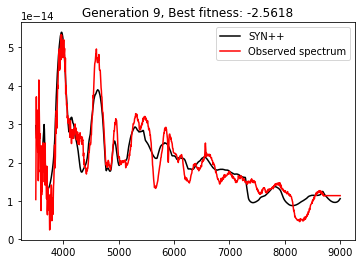

 18%|█▊        | 9/50 [1:29:02<7:08:19, 626.81s/generation]

Generation 10, Best fitness: -2.616299911027663


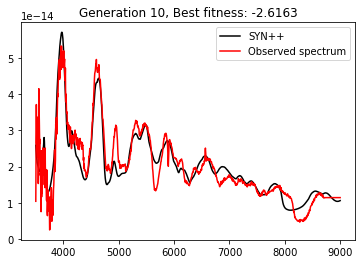

 20%|██        | 10/50 [1:42:47<7:38:33, 687.84s/generation]

Generation 11, Best fitness: -2.6594258187634567


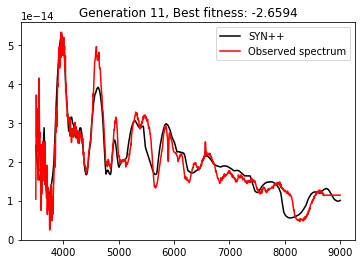

 22%|██▏       | 11/50 [1:57:02<8:00:21, 739.00s/generation]

Generation 12, Best fitness: -2.7278903623880475


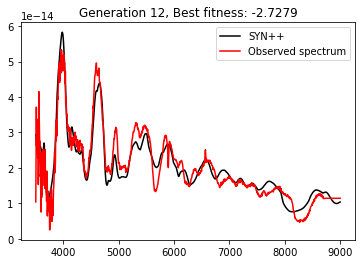

 24%|██▍       | 12/50 [2:13:41<8:38:11, 818.18s/generation]

Generation 13, Best fitness: -2.7278903623880475


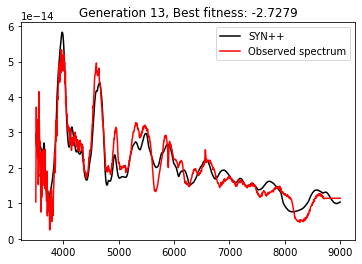

 26%|██▌       | 13/50 [2:31:48<9:14:42, 899.53s/generation]

mutation probability improved: mutpb=0.4
individual probability improved: indpb=0.4
crossover probability decrease: indpb=0.6
Generation 14, Best fitness: -2.731531781858265


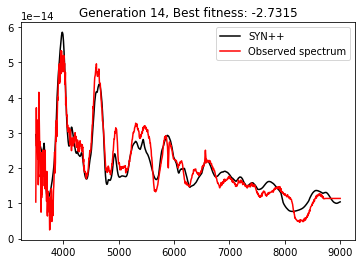

 28%|██▊       | 14/50 [2:49:11<9:25:42, 942.84s/generation]

Generation 15, Best fitness: -2.7879776509481795


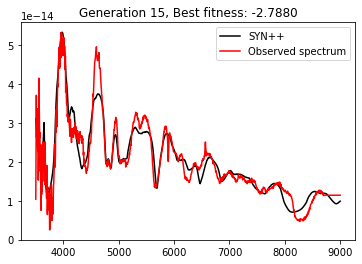

 30%|███       | 15/50 [3:07:01<9:32:20, 981.17s/generation]

Generation 16, Best fitness: -2.8252576809610876


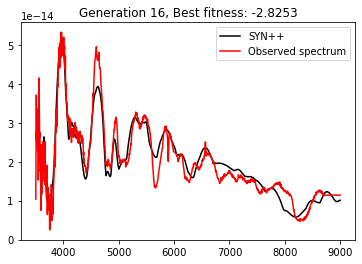

 32%|███▏      | 16/50 [3:24:43<9:29:53, 1005.68s/generation]

Generation 17, Best fitness: -2.8772545644659817


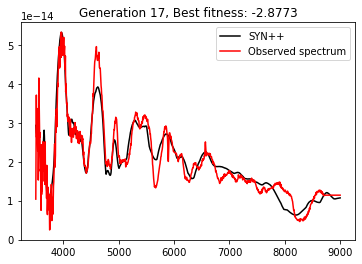

 34%|███▍      | 17/50 [3:42:27<9:22:44, 1023.17s/generation]

Generation 18, Best fitness: -2.8772545644659817


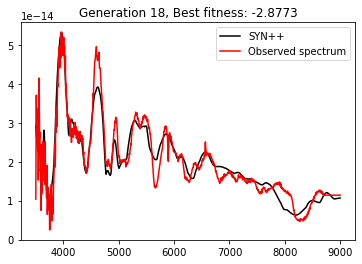

 36%|███▌      | 18/50 [3:59:36<9:06:39, 1024.99s/generation]

mutation probability improved: mutpb=0.4
individual probability improved: indpb=0.4
crossover probability decrease: indpb=0.6
Generation 19, Best fitness: -2.8866380014494752


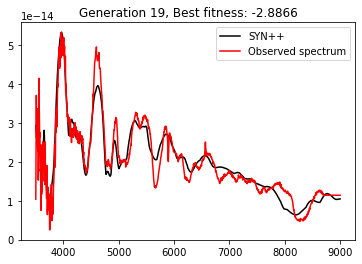

 38%|███▊      | 19/50 [4:16:37<8:48:53, 1023.66s/generation]

Generation 20, Best fitness: -2.911732799494284


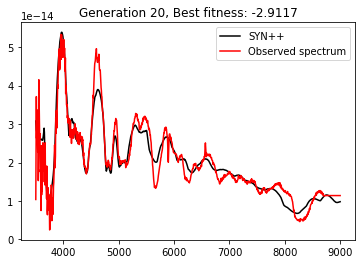

 40%|████      | 20/50 [4:33:57<8:34:22, 1028.74s/generation]

Generation 21, Best fitness: -2.9176696200939034


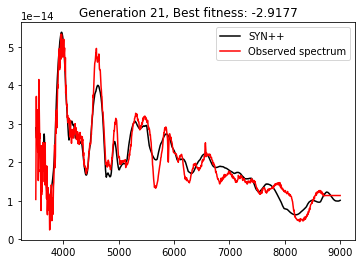

 42%|████▏     | 21/50 [4:51:24<8:19:50, 1034.16s/generation]

Generation 22, Best fitness: -2.9449676776911957


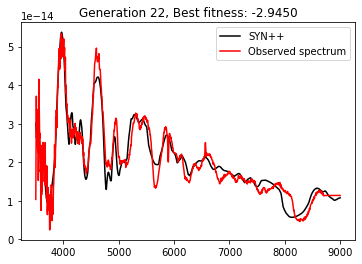

 44%|████▍     | 22/50 [5:07:47<7:55:24, 1018.73s/generation]

Generation 23, Best fitness: -2.9449676776911957


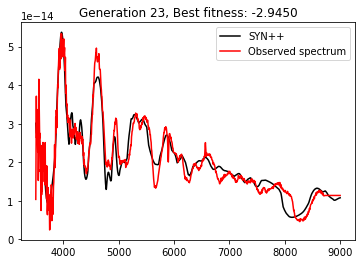

 46%|████▌     | 23/50 [5:23:23<7:27:12, 993.80s/generation] 

mutation probability improved: mutpb=0.4
individual probability improved: indpb=0.4
crossover probability decrease: indpb=0.6
Generation 24, Best fitness: -2.9449676776911957


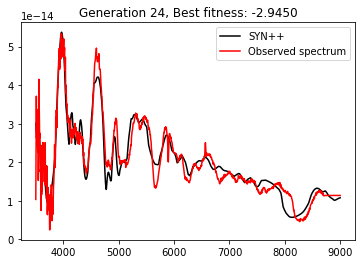

 48%|████▊     | 24/50 [5:37:57<6:55:04, 957.87s/generation]

mutation probability improved: mutpb=0.6
individual probability improved: indpb=0.5
crossover probability decrease: indpb=0.5
Generation 25, Best fitness: -2.953736216049336


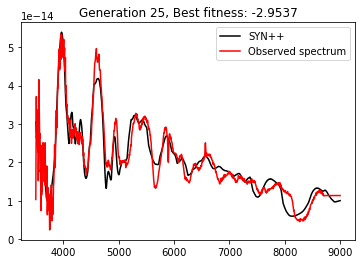

 50%|█████     | 25/50 [5:52:15<6:26:40, 928.02s/generation]

Generation 26, Best fitness: -2.9665077331232452


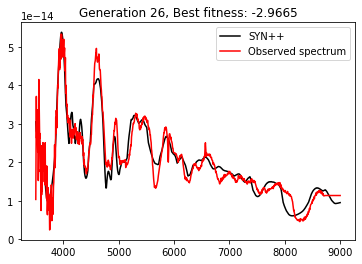

 52%|█████▏    | 26/50 [6:06:12<6:00:14, 900.61s/generation]

Generation 27, Best fitness: -3.0342557475404


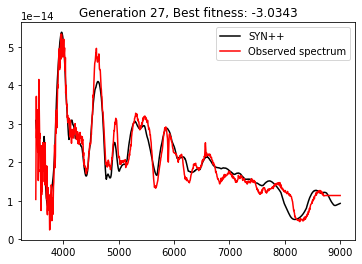

 54%|█████▍    | 27/50 [6:19:32<5:33:39, 870.39s/generation]

Generation 28, Best fitness: -3.0342557475404


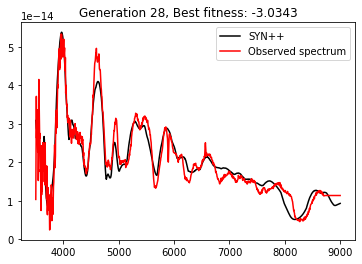

 56%|█████▌    | 28/50 [6:32:54<5:11:40, 850.05s/generation]

mutation probability improved: mutpb=0.4
individual probability improved: indpb=0.4
crossover probability decrease: indpb=0.6
Generation 29, Best fitness: -3.0342557475404


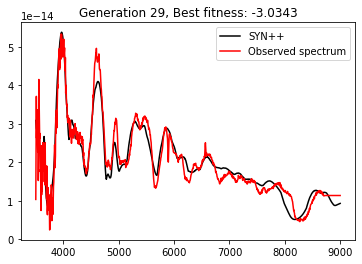

 58%|█████▊    | 29/50 [6:46:39<4:54:49, 842.36s/generation]

mutation probability improved: mutpb=0.6
individual probability improved: indpb=0.5
crossover probability decrease: indpb=0.5
Generation 30, Best fitness: -3.0342557475404


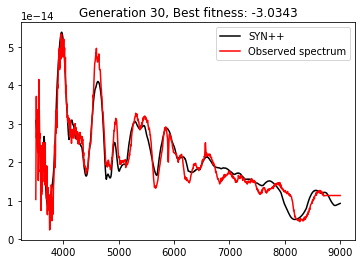

 60%|██████    | 30/50 [6:59:53<4:36:01, 828.08s/generation]

mutation probability improved: mutpb=0.6
individual probability improved: indpb=0.6
crossover probability decrease: indpb=0.5
Generation 31, Best fitness: -3.0342557475404


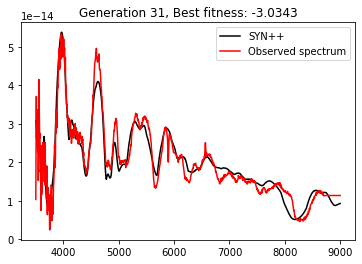

 62%|██████▏   | 31/50 [7:13:28<4:20:54, 823.90s/generation]

mutation probability improved: mutpb=0.6
individual probability improved: indpb=0.6
crossover probability decrease: indpb=0.5
Generation 32, Best fitness: -3.0342557475404


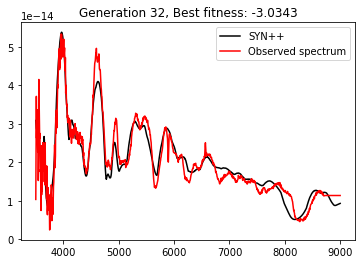

 64%|██████▍   | 32/50 [7:26:21<4:02:37, 808.77s/generation]

mutation probability improved: mutpb=0.6
individual probability improved: indpb=0.6
crossover probability decrease: indpb=0.5
Generation 33, Best fitness: -3.0505514296528475


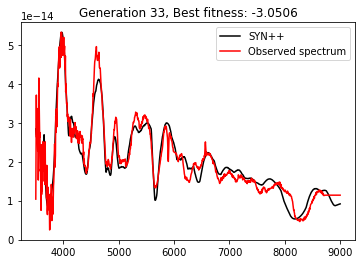

 66%|██████▌   | 33/50 [7:39:15<3:46:09, 798.19s/generation]

Generation 34, Best fitness: -3.075909088235715


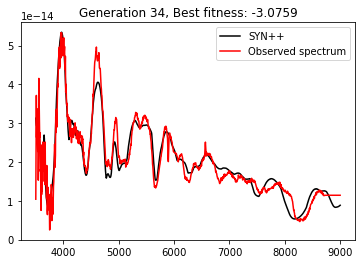

 68%|██████▊   | 34/50 [7:52:24<3:32:07, 795.46s/generation]

Generation 35, Best fitness: -3.097695033474188


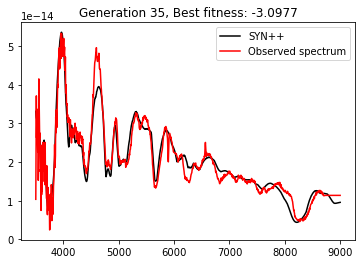

 70%|███████   | 35/50 [8:05:28<3:18:00, 792.03s/generation]

Generation 36, Best fitness: -3.097695033474188


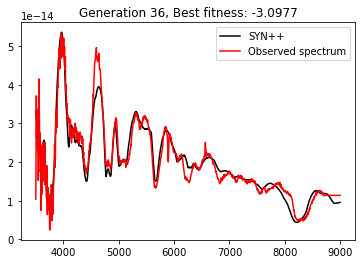

 72%|███████▏  | 36/50 [8:18:15<3:03:02, 784.49s/generation]

mutation probability improved: mutpb=0.4
individual probability improved: indpb=0.4
crossover probability decrease: indpb=0.6
Generation 37, Best fitness: -3.14270073470976


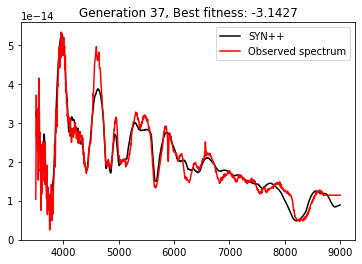

 74%|███████▍  | 37/50 [8:30:48<2:47:57, 775.19s/generation]

Generation 38, Best fitness: -3.14270073470976


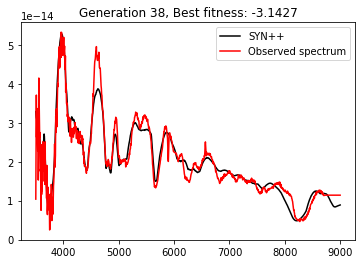

 76%|███████▌  | 38/50 [8:43:23<2:33:48, 769.08s/generation]

mutation probability improved: mutpb=0.4
individual probability improved: indpb=0.4
crossover probability decrease: indpb=0.6
Generation 39, Best fitness: -3.1600181946127464


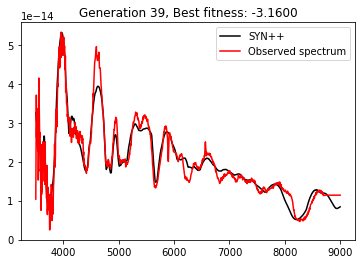

 78%|███████▊  | 39/50 [8:55:42<2:19:20, 760.01s/generation]

Generation 40, Best fitness: -3.1930254857201192


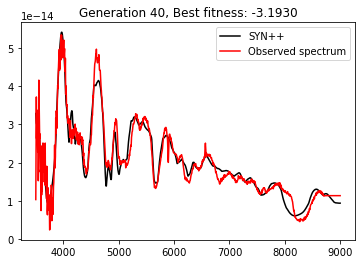

 80%|████████  | 40/50 [9:07:59<2:05:31, 753.13s/generation]

Generation 41, Best fitness: -3.213595584485676


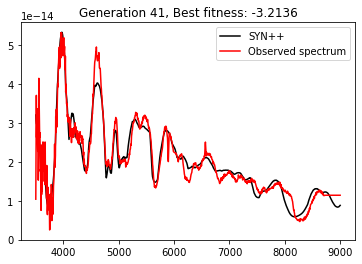

 82%|████████▏ | 41/50 [9:20:27<1:52:43, 751.53s/generation]

Generation 42, Best fitness: -3.213595584485676


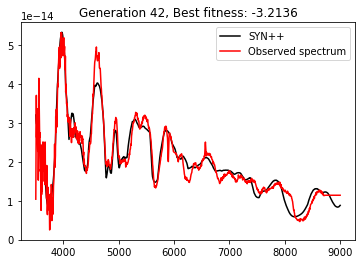

 84%|████████▍ | 42/50 [9:32:52<1:39:57, 749.65s/generation]

mutation probability improved: mutpb=0.4
individual probability improved: indpb=0.4
crossover probability decrease: indpb=0.6
Generation 43, Best fitness: -3.2611093625720513


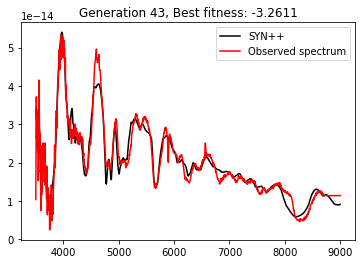

 86%|████████▌ | 43/50 [9:45:12<1:27:08, 746.91s/generation]

Generation 44, Best fitness: -3.2626678114143535


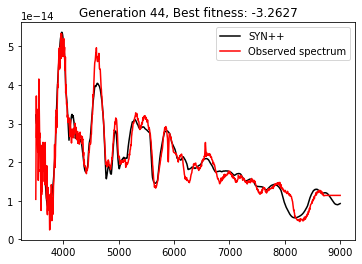

 88%|████████▊ | 44/50 [9:58:03<1:15:24, 754.09s/generation]

Generation 45, Best fitness: -3.2717635378665797


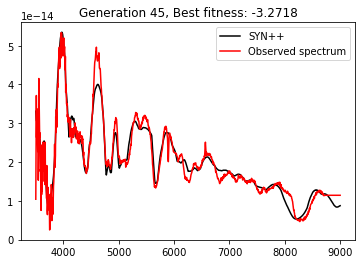

 90%|█████████ | 45/50 [10:11:02<1:03:26, 761.36s/generation]

Generation 46, Best fitness: -3.2807873768271083


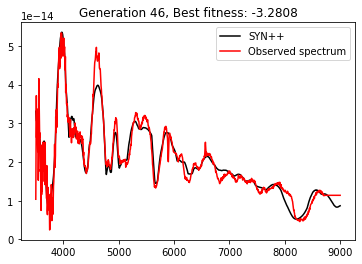

 92%|█████████▏| 46/50 [10:23:56<51:01, 765.32s/generation]  

Generation 47, Best fitness: -3.300169504277148


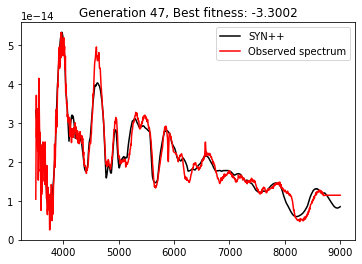

 94%|█████████▍| 47/50 [10:36:45<38:19, 766.43s/generation]

Generation 48, Best fitness: -3.30849037167862


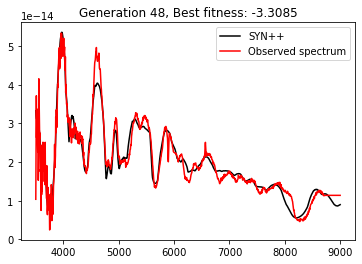

 96%|█████████▌| 48/50 [10:49:42<25:38, 769.45s/generation]

Generation 49, Best fitness: -3.3158286116263693


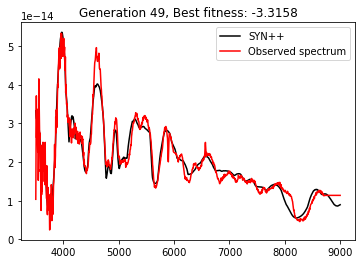

 98%|█████████▊| 49/50 [11:02:31<12:49, 769.32s/generation]

Generation 50, Best fitness: -3.3189846174681588


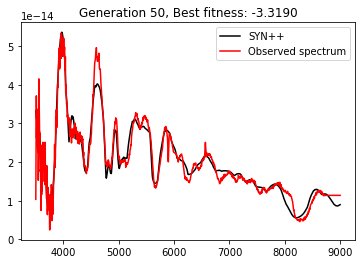

100%|██████████| 50/50 [11:15:04<00:00, 810.08s/generation]

Best Individual =  [8.8591138513478, 12.617897227174547, 21.824377279098858, 16.82925280514061, 22.860694365232934, 24.69242757705559, 23.124439600267625, 19.64525706726204, -0.6673459523173368, -0.2507346072711903, -2.0, -0.2834137387586719, 2.266083704567199, 1.1092928206311616, 11.304911665180548, 9.226491477368121, 1.2861141668938176, 1.0, 3.6768103102538126, 9.734351882084269, 9.006719948623658, 9.95208322080418, 7.666525241138295, 3.110981537069696, 2.409763109664148, 1.0, 1.7899279761530673, 3.1015278411253284, 15.190111379640971, 15.25291642473856, 10.23555316455895, 9.265416781561509]
Best Fitness =  -3.3189846174681588


In [12]:
import numpy as np
from scipy.stats import pearsonr
from deap import base, creator, tools, algorithms
from scipy.stats import PearsonRNearConstantInputWarning,PearsonRConstantInputWarning
import warnings
warnings.filterwarnings("ignore",category=PearsonRNearConstantInputWarning)
warnings.filterwarnings("ignore",category=PearsonRConstantInputWarning)

# 定义光谱物理模型
def spectral_model(params):
    # 这里是一个示例模型，实际模型应根据你的具体情况定义
    # return np.sin(np.linspace(0, 10, 100) + params[0]) * params[1]
    spec_synpp=synpp_.invoke_synpp_param(params)[:,1]

    return spec_synpp

# 定义评价函数
def evaluate(individual, observed_spectrum):
    model_spectrum = spectral_model(individual)
    corr, _ = pearsonr(model_spectrum, observed_spectrum)
    if corr==0 or np.isnan(corr):corr=1e-32
    return (np.log(1-corr),)  # 返回负的相关系数作为适应度，因为遗传算法是最小化问题
import multiprocessing
pool=multiprocessing.Pool(processes=4)
# 创建遗传算法所需的类和函数
# 创建遗传算法的类和工具
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # 最小化问题
creator.create("Individual", list, fitness=creator.FitnessMin)

# 假设我们有3个参数，它们的范围分别是:
# param_bounds = [(-5, 5), (-10, 3), (0, 1)]  # 每个元组代表一个参数的(min, max)
param_bounds = synpp_.generate_bounds()

# 定义参数生成函数
def uniform_params( bounds):
    """根据给定的范围生成均匀分布的参数值列表"""
    # p=[np.random.uniform(low, high) for low, high in bounds]
    # print(p)
    # return p 
    return [np.random.uniform(low, high) for low, high in bounds]
toolbox = base.Toolbox()
# 注册参数生成函数
toolbox.register("attr_floats", uniform_params,  bounds=param_bounds)
# 创建个体操作
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_floats)
# 创建种群操作
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# toolbox = base.Toolbox()
# toolbox.register("attr_float", np.random.uniform, -5, 5)  # 参数范围
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=2)  # 参数数量
# toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 观测光谱
# observed_spectrum = np.sin(np.linspace(0, 10, 100) + 1.5) * 0.9
data_name="/home/ysy/_data/source/2020adow/spec/spectra/TEXT/sn2020adow-20210113.320.coadd.blotch-ui.dat"
data_name="/home/ysy/_data/source/2014C/Spec/Deredden_2014C_140107_LJT_G3.dat"
data_name="/home/ysy/_data/source/2014C/Spec/2014C/Deredden_2014C_140108_LJT_G3.dat"
data_name="/home/ysy/_data/source/2014C/Spec/2014C/Deredden_2014C_140118_LJT_G3.dat"
spec_data=np.loadtxt(data_name)
spec_data[:,0]=spec_data[:,0]/(1+0.0027)
spec_obs,_=synpp_.resample_observed_spec(spec_data)
observed_spectrum = spec_obs[:,1]

# 评价函数注册
toolbox.register("evaluate", evaluate, observed_spectrum=observed_spectrum)
param_type=synpp_.param_type
def cxUniform_ions(ind1, ind2, indpb,param_type):
    """Executes a uniform crossover that modify in place the two
    :term:`sequence` individuals. The attributes are swapped according to the
    *indpb* probability.

    :param ind1: The first individual participating in the crossover.
    :param ind2: The second individual participating in the crossover.
    :param indpb: Independent probability for each attribute to be exchanged.
    :returns: A tuple of two individuals.

    This function uses the :func:`~random.random` function from the python base
    :mod:`random` module.
    """
    ind1_np=np.array(ind1)
    ind2_np=np.array(ind2)
    cx_index_all=list(np.where(param_type[2]=="photosphere")[0])
    all_ions=np.unique(param_type[1][param_type[2]=="ion"])
    for i in all_ions:
        cx_index_all.append((np.where(param_type[1]==i)[0]))
    # print(cx_index_all)
    # print(all_ions)

    for i in range(len(cx_index_all)):
        if np.random.random() < indpb:
            ind1_np[cx_index_all[i]], ind2_np[cx_index_all[i]] = ind2_np[cx_index_all[i]], ind1_np[cx_index_all[i]]
    for i,(i1,i2) in enumerate(zip(ind1_np,ind2_np)):
        ind1[i]=i1
        ind2[i]=i2
    return ind1, ind2
# toolbox.register("mate", tools.cxBlend, alpha=0.5)  # 交叉操作
# toolbox.register("mate", tools.cxTwoPoint,)  # 交叉操作
toolbox.register("mate", cxUniform_ions,indpb=0.5,param_type=param_type,)  # 交叉操作
# toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=2, indpb=0.2)  # 变异操作

def mutGaussianWithRange(individual, mu, indpb, ranges):
    # print(1,individual)
    lwlimt=np.array(ranges)[:,0]
    uplimt=np.array(ranges)[:,1]
    individual_np=np.array(individual)
    mutated_index=np.where(np.random.random(len(individual)) < indpb)
    random_sigma=np.abs(uplimt[mutated_index]-lwlimt[mutated_index])*0.2
    mutated_value = individual_np[mutated_index] + np.array([np.random.normal(mu, random_sigma[i],) for i in range(len(mutated_index[0]))])
    individual_np[mutated_index] = np.clip(mutated_value,
                                           lwlimt[mutated_index],
                                           uplimt[mutated_index])# 将变异后的值限制在指定范围内
    individual_np=np.clip(individual_np,lwlimt,uplimt)
    # print(mutated_index)
    # print(individual)
    # print(lwlimt)
    # np.set_printoptions(precision=2)  
    # print(individual_np)
    # print(mutated_value,)
    # print(uplimt)
    # for  i in range(len(mutated_index[0])):individual[mutated_index[0][i]]=individual_np[mutated_index[0][i]]
    for  i in range(len(individual_np)):individual[i]=individual_np[i]
    # print(2,individual)
    return individual,

indpb_0=0.3
ranges=synpp_.generate_bounds()
toolbox.register("mutate", mutGaussianWithRange, mu=0, indpb=indpb_0,ranges=ranges)  # 变异操作
toolbox.register("select", tools.selTournament, tournsize=3)  # 选择操作


# 遗传算法参数
population_size = 300
crossover_probability_0 = 0.7
mutation_probability_0 = 0.2
number_of_generations =50
indpb_mate_0=0.5
crossover_probability = crossover_probability_0
mutation_probability=mutation_probability_0
individual_probability=indpb_0
individual_probability_mate=indpb_mate_0

# 初始化种群
pop = toolbox.population(n=population_size)

# # 运行遗传算法
# result = algorithms.eaSimple(pop, toolbox, cxpb=crossover_probability, mutpb=mutation_probability, ngen=number_of_generations, verbose=True)
best_ind_per_generation=[]
best_ind = None



import tqdm
pop_all=[]
convergence_generation=1
max_convergence_generation=8
for gen in tqdm.tqdm(range(number_of_generations), unit="generation"):
    # 进化算法的一代
    # toolbox.register("mutate", mutGaussianWithRange, mu=0, sigma=2, indpb=individual_probability,ranges=ranges)  # 变异操作
    toolbox.mutate.indpb=individual_probability
    toolbox.mate.indpb=individual_probability_mate
    offspring = algorithms.varAnd(pop, toolbox, cxpb=crossover_probability, mutpb=mutation_probability)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    pop = toolbox.select(offspring, k=len(pop))
    
    # 计算当前种群的最佳个体
    current_best = tools.selBest(pop, k=1)[0]
    if best_ind is None or current_best.fitness > best_ind.fitness:
        best_ind = current_best
    # print(best_ind)
    # print(best_ind.__dict__)
    best_fitness=best_ind.fitness.values[0]
    print(f"Generation {gen + 1}, Best fitness: {best_fitness}")
    plt.figure()
    synpp_.plot_synpp_result(best_ind,spec_obs)
    plt.title(f"Generation {gen + 1}, Best fitness: {best_fitness:.4f}")
    plt.show()
    if gen>0:
        if best_fitness==best_ind_per_generation[-1][1]:
            convergence_generation +=1
            mutation_probability   +=0.2
            individual_probability +=0.1
            crossover_probability  -=0.1
            individual_probability_mate +=0.1
            mutation_probability   =np.nanmin([mutation_probability,0.6])
            individual_probability =np.nanmin([individual_probability,0.6])
            crossover_probability  =np.nanmax([crossover_probability,0.5])
            individual_probability_mate=np.nanmin([individual_probability_mate,0.8])
            print(f"mutation probability improved: mutpb={mutation_probability}")
            print(f"individual probability improved: indpb={individual_probability}")
            print(f"crossover probability decrease: indpb={crossover_probability}")
        else:
            convergence_generation = 1
            individual_probability = indpb_0
            mutation_probability   = mutation_probability_0
            crossover_probability  = crossover_probability_0
            individual_probability_mate = indpb_mate_0
    
    # print(best_ind)
    # for p in pop: print(p)
    best_ind_per_generation.append([gen]+[best_fitness]+list(best_ind))
    pop_all.append(pop)
    np.savetxt("best_params_SN2014C_140118_240918_NoSi.txt",best_ind_per_generation)
    # synpp_.invoke_synpp_param()
    
    if convergence_generation>=max_convergence_generation:break
    # 输出当前最佳个体

# # 最终输出最佳个体
# print("Final best individual:", best_ind)

pool.close()
pool.join()

# 最优参数输出
best_ind = tools.selBest(pop, 1)[0]

import pickle
pickle_name="results_SN2014C_140118_240918_NoSi.pkl"
with open(pickle_name,"wb") as f:
    pickle.dump(pop,f)

print("Best Individual = ", best_ind)
print("Best Fitness = ", best_ind.fitness.values[0])

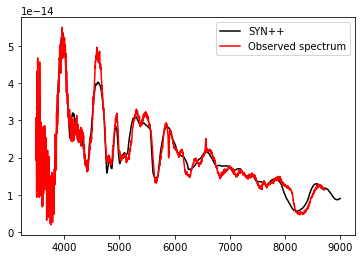

In [13]:
synpp_.plot_synpp_result(best_ind,spec_data)
best_ind_yaml_name="SN2014C_syn++.best_140107.yaml"
best_ind_yaml_name="SN2014C_syn++.best_140108.yaml"
best_ind_yaml_name="SN2014C_syn++.best_140118_NoHI.yaml"
best_ind_yaml_name="SN2014C_syn++.best_140118_NoSi.yaml"
# best_ind_yaml_name="SN2014C_syn++.best_140108_NoHI.yaml"
# best_ind_yaml_name="SN2014C_syn++.best_140108_NoSi.yaml"
synpp_.param_creat_new_yaml(best_ind,best_ind_yaml_name)

ES Done.
H_I Done.
He_I Done.
O_I Done.
Mg_II Done.
Ca_II Done.
Fe_II Done.
BB Done.


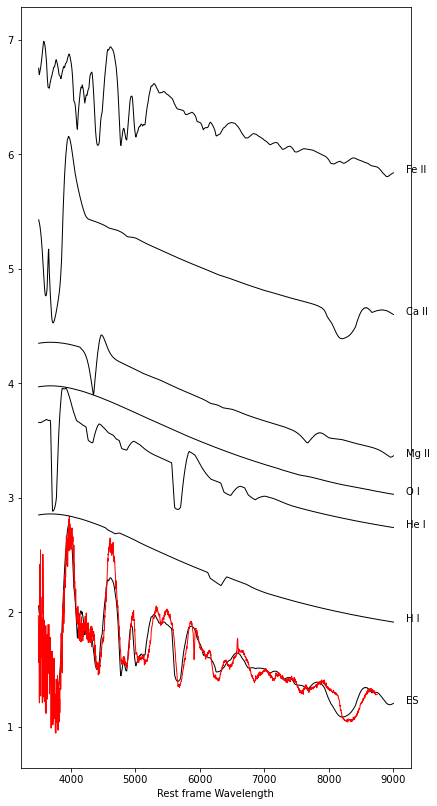

In [14]:
synpp_yaml(best_ind_yaml_name,fix_v_max=False).plot_synpp_ions(spec_name=data_name,delete_yaml=False)
# plt.savefig("/home/ysy/Share/SN2014C_syn++.best_140107.png")
# plt.savefig("/home/ysy/Share/SN2014C_syn++.best_140108_NoSi.png")
# plt.savefig("/home/ysy/Share/SN2014C_syn++.best_140108.png")
# plt.savefig("/home/ysy/Share/SN2014C_syn++.best_140118.png")
plt.savefig("/home/ysy/Share/SN2014C_syn++.best_140118_NoSi.png")
# plt.savefig("/home/ysy/Share/SN2014C_syn++.best_140118_NoHI.png")

In [15]:
aaaaaaaaaaaaaaaaaaaaaaaaaaa

NameError: name 'aaaaaaaaaaaaaaaaaaaaaaaaaaa' is not defined

In [ ]:
aaaaaaaaaaaaaaaaaaa

NameError: name 'aaaaaaaaaaaaaaaaaaa' is not defined

In [ ]:
np.corrcoef

TypeError: _corrcoef_dispatcher() missing 1 required positional argument: 'x'

(array([ 1., 16.,  0., 10.,  2.,  2.,  4.,  8.,  1.,  6.]),
 array([-5.18198421, -0.52082069,  4.14034283,  8.80150635, 13.46266987,
        18.12383339, 22.78499691, 27.44616043, 32.10732395, 36.76848747,
        41.42965099]),
 <BarContainer object of 10 artists>)

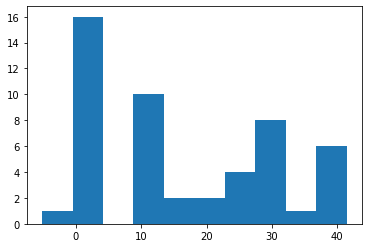

In [ ]:
best_ind

[13.676805580758083,
 6.308408543424371,
 -5.265347153462173,
 -0.11876945036451438,
 -13.235963121414732,
 -3.8641858571683843,
 2.5940240446708196,
 0.5927587844362391,
 15.713177826670272,
 2.2442179161982674,
 5.203400421025339,
 -0.5419188244822959,
 8.58111846755881,
 10.445849340192773,
 6.260594146364687,
 6.939188936601618,
 2.029421705425552,
 2.2105334721356673,
 2.7471348597004206,
 7.49223580634048,
 16.142655617441676,
 8.410287805945826,
 39.52334966293925,
 2.5821234545862946,
 7.373890965225459,
 8.719500536928805]

Generation 1, Best fitness: -2.414616477274741


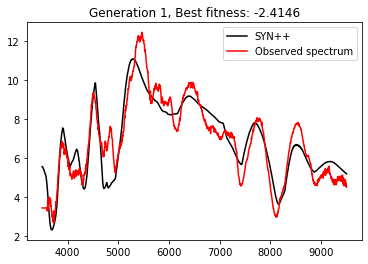

KeyboardInterrupt: 

In [ ]:
with open(pickle_name,"rb") as f:
    pre_pop=pickle.load(f)
for gen in range(number_of_generations):
    # 进化算法的一代
    offspring = algorithms.varAnd(pre_pop, toolbox, cxpb=crossover_probability, mutpb=mutation_probability)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    pre_pop = toolbox.select(offspring, k=len(pre_pop))
    
    # 计算当前种群的最佳个体
    current_best = tools.selBest(pre_pop, k=1)[0]
    if best_ind is None or current_best.fitness > best_ind.fitness:
        best_ind = current_best
    # print(best_ind)
    # print(best_ind.__dict__)
    best_fitness=best_ind.fitness.values[0]
    print(f"Generation {gen + 1}, Best fitness: {best_fitness}")
    plt.figure()
    synpp_.plot_synpp_result(best_ind,spec_obs)
    plt.title(f"Generation {gen + 1}, Best fitness: {best_fitness:.4f}")
    plt.show()
    if gen>0:
        if best_fitness==best_ind_per_generation[-1][1]:
            mutation_probability +=0.2
            mutation_probability =np.nanmin([mutation_probability,0.6])
            print(f"mutation probability improved: mutpb={mutation_probability}")
        else:
            mutation_probability = mutation_probability_0
    best_ind_per_generation.append([gen]+[best_fitness]+list(best_ind))
    np.savetxt("best_params.txt",best_ind_per_generation)
    # synpp_.invoke_synpp_param()
    

    # 输出当前最佳个体

# # 最终输出最佳个体
# print("Final best individual:", best_ind)

pool.close()
pool.join()
# 最优参数输出
best_ind = tools.selBest(pre_pop, 1)[0]

In [ ]:
np.savetxt(fname="best_param.dat",X=np.array(best_ind))

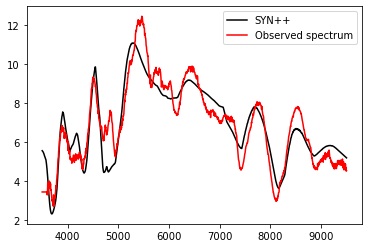

In [ ]:
plt.figure()
synpp_.plot_synpp_result(best_ind,spec_obs)
plt.show()

In [ ]:
ion_arg=np.where(Synpp_yaml["setups"][0]['active'])
ion_num=len(ion_arg[0])

v_phot_rand=np.random.uniform(low=5,high=15,size=N_sample)
t_phot_rand=np.random.uniform(low=5,high=30,size=N_sample)

log_tau_rand=np.random.uniform(low=-1.0,high=1 ,size=(N_sample,ion_num))
v_min_rand  =np.random.uniform(low=1   ,high=15,size=(N_sample,ion_num))
aux_rand    =np.random.uniform(low=1   ,high=10,size=(N_sample,ion_num))
temp_rand   =np.random.uniform(low=1   ,high=10,size= N_sample)


for syn_id in range(1,N_sample):
    New_syapp_yaml=copy.deepcopy(Synpp_yaml)
    # TODO range of output wavelength
    # TODO flux scale and shift
    # or不同的scale 迭代岭回归
    New_syapp_yaml["setups"][0]["t_phot"]=t_phot_rand[syn_id]
    New_syapp_yaml["setups"][0]["v_phot"]=v_phot_rand[syn_id]

    log_tau_tmp=np.array(New_syapp_yaml["setups"][0]["log_tau"])
    aux_tmp    =np.array(New_syapp_yaml["setups"][0]["aux"])
    v_min_tmp  =np.array(New_syapp_yaml["setups"][0]["v_min"])
    temp_tmp   =np.array(New_syapp_yaml["setups"][0]["temp"])

    log_tau_tmp[ion_arg]=log_tau_rand[syn_id]
    v_min_tmp  [ion_arg]=v_min_rand[syn_id]
    aux_tmp    [ion_arg]=aux_rand[syn_id]
    temp_tmp   [ion_arg]=temp_rand[syn_id]

    New_syapp_yaml["setups"][0]["aux"]    =list(aux_tmp)
    New_syapp_yaml["setups"][0]["log_tau"]=list(log_tau_tmp)
    New_syapp_yaml["setups"][0]["v_min"]  =list(v_min_tmp)
    New_syapp_yaml["setups"][0]["temp"]   =list(temp_tmp)

    new_yaml_name=spec_base+"."+str(syn_id).zfill(zfill)+".yaml"
    # with open(new_yaml_name,"w") as f:
    #     print (Synpp.create(New_syapp_yaml),file=f)

# spec_synpp=invoke_synpp(Ion_yaml_name)[:,:2]
# plt.plot(spec_synpp[:,0],spec_synpp[:,1])


random_data=np.concatenate((t_phot_rand.reshape(-1,1),
                            v_phot_rand.reshape(-1,1),
                            v_min_rand,
                            log_tau_rand,
                            aux_rand,
                            temp_rand.reshape(-1,1)
                            ),axis=1)[:-1]
np.savetxt("random_param.txt",random_data)
random_data.shape

NameError: name 'Synpp_yaml' is not defined

In [ ]:
qqqqqqqqqqqqqqq

In [ ]:
# Synpp_yaml    =yaml.load(open(yaml_file,"r"),Loader=yaml.CLoader)

# ion_arg=np.where(Synpp_yaml["setups"][0]['active'])
# ion_num=len(ion_arg[0])

# v_phot_rand=np.random.uniform(low=5,high=15,size=N_sample)
# t_phot_rand=np.random.uniform(low=5,high=30,size=N_sample)

# log_tau_rand=np.random.uniform(low=-1.0,high=1 ,size=(N_sample,ion_num))
# v_min_rand  =np.random.uniform(low=1   ,high=15,size=(N_sample,ion_num))
# aux_rand    =np.random.uniform(low=1   ,high=10,size=(N_sample,ion_num))
# temp_rand   =np.random.uniform(low=1   ,high=10,size= N_sample)

# random_data=np.concatenate((t_phot_rand.reshape(-1,1),
#                             v_phot_rand.reshape(-1,1),
#                             v_min_rand,
#                             log_tau_rand,
#                             aux_rand,
#                             temp_rand.reshape(-1,1)
#                             ),axis=1)[:-1]

# np.savetxt("random_param.txt",random_data)
# print(random_data.shape)
# old_yaml_name=spec_base+"."+"0".zfill(zfill)+".yaml"
# for syn_id in range(1,N_sample):
#     new_yaml_name=spec_base+"."+str(syn_id).zfill(zfill)+".yaml"

#     repalce_param(old_yaml_name,new_yaml_name,random_data[syn_id])

# # spec_synpp=invoke_synpp(Ion_yaml_name)[:,:2]
# # plt.plot(spec_synpp[:,0],spec_synpp[:,1])




In [ ]:
# with open("synpp_cmd.sh","w") as f:
#     for  in range(1,N_sample):
#         new_yaml_name=spec_base+"."+str(syn_id).zfill(zfill)+".yaml"
#         new_data_name=spec_base+"."+str(syn_id).zfill(zfill)+".dat"
#         new_cmd=" ".join(["syn++",new_yaml_name,">",new_data_name,])
#         print("echo %d"%syn_id,file=f)
#         print(new_cmd,file=f)

In [ ]:
import time
from tqdm import tqdm  
for syn_id in tqdm(range(1,N_sample), desc="处理进度", ncols=100):  
    new_yaml_name=spec_base+"."+str(syn_id).zfill(zfill)+".yaml"
    new_data_name=spec_base+"."+str(syn_id).zfill(zfill)+".dat"
    new_cmd=" ".join(["syn++",new_yaml_name,">",new_data_name,])
    os.system(new_cmd)

处理进度:   0%|                                                            | 0/3999 [00:00<?, ?it/s]

处理进度: 100%|█████████████████████████████████████████████████| 3999/3999 [40:32<00:00,  1.64it/s]


In [ ]:
# os.chdir("../new_yaml_all_2/")
spec_data[:,0]

array([3500., 3505., 3510., ..., 9490., 9495., 9500.])

In [ ]:
os.chdir("/home/ysy/_data/source/2020adow/spec/synpp/")
data_name="SN2011fe_20110829_Gemini_N_GMOS.dat"
data_name="/home/ysy/_data/source/2020adow/spec/spectra/TEXT/sn2020adow-20210113.320.coadd.blotch-ui.dat"
spec_data=np.loadtxt(data_name)
spec_data[:,0]=spec_data[:,0]/(1+0.007505)
os.chdir("/home/ysy/_data/source/2020adow/spec/synpp/new_yaml_all_3/")
yaml_name="SN2020adow_syn++.0001.yaml"
# spec_range=[min(spec_data[:,0]),max(spec_data[:,0])]

spec_data,spec_range=spec_interp_wv(spec_data,yaml_name)
spec_data=spec_norm(spec_data)

syn_id=1
new_data_name=spec_base+"."+str(syn_id).zfill(zfill)+".dat"
spec_syn_test=np.loadtxt(new_data_name)[:,:2]

synpp_result_arg=np.where(((spec_syn_test[:,0]>spec_range[0]) & (spec_syn_test[:,0]<spec_range[1])))


ls: cannot access 'aaa': No such file or directory
SN2020adow_syn++.0001.yaml


In [ ]:
for syn_id in range(1,N_sample):
    new_data_name=spec_base+"."+str(syn_id).zfill(zfill)+".dat"
    spec_syn_train=np.loadtxt(new_data_name)[:,1]
    if syn_id==1: spec_syn_all=spec_syn_train.reshape(1,-1)
    else:spec_syn_all=np.append(spec_syn_all,spec_syn_train.reshape(1,-1),axis=0)
# spec_syn_all.shape
# "random_param.txt"
# 2m 3.4s

光谱匹配成功！相关系数： 0.995828144353233
1401


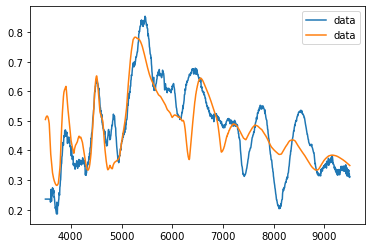

In [ ]:
import numpy as np
from scipy.stats import pearsonr

def spectrum_matching(spectrum1, spectrum2, threshold=0.8):
    """
    使用皮尔逊相关系数进行光谱匹配
    
    参数：
        spectrum1: 第一个光谱的特征谱线（numpy数组）
        spectrum2: 第二个光谱的特征谱线（numpy数组）
        threshold: 相关系数的阈值，用于判断匹配程度（默认为0.8）
        
    返回：
        matched: 是否匹配的布尔值
        correlation_coefficient: 相关系数
    """
    # 数据预处理（可选）
    # spectrum1 = (spectrum1 - np.mean(spectrum1)) / np.std(spectrum1)
    # spectrum2 = (spectrum2 - np.mean(spectrum2)) / np.std(spectrum2)
    
    # 计算相关系数
    correlation_coefficient, _ = pearsonr(spectrum1, spectrum2)
    
    # 判断是否匹配
    matched = correlation_coefficient >= threshold
    
    return matched, correlation_coefficient

# 示例光谱数据
spectrum1 = np.array([1, 2, 3, 4, 5])
spectrum2 = np.array([1, 2.2, 2.8, 3.9, 5])

# 进行光谱匹配
matched, correlation_coefficient = spectrum_matching(spectrum1, spectrum2)

# 输出结果
if matched:
    print("光谱匹配成功！相关系数：", correlation_coefficient)
else:
    print("光谱匹配失败。相关系数：", correlation_coefficient)

correlation_coefficient_all=np.array([])
for i in spec_syn_all:
    m,cc=spectrum_matching(i,spec_data[:,1])
    correlation_coefficient_all=np.append(correlation_coefficient_all,cc)
max_correlation_coefficient_all_index=np.where(correlation_coefficient_all==np.nanmax(correlation_coefficient_all))[0][0]

plt.figure()
plt.plot(spec_data[:,0],spec_data[:,1],label="data")

param,_=curve_fit(f=spec_match_template,
                    xdata=spec_syn_all[max_correlation_coefficient_all_index],
                    ydata=spec_data[:,1],method="lm")
plt.plot(spec_data[:,0],spec_syn_all[max_correlation_coefficient_all_index]*param[0]+param[1],label="data")
plt.legend()
# print(chi2_all[min_chi2_index])
# print(min_chi2_index)
print(max_correlation_coefficient_all_index)

191.26566416094212
1401


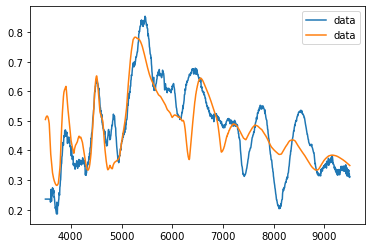

In [ ]:
# class match_template:
#     def __init__(self,spec_template): 
#         self.spec_template=spec_template

def spec_match_template(flux,a,b):
    return a*flux+b
chi2_all=np.array([])

w=np.abs(np.diff(spec_data[:,1]))
w[w==0]=0.01
w=1/np.append(w,w[-1])**0.5

for i in spec_syn_all:
    param,_=curve_fit(f=spec_match_template,
                      xdata=i,
                      ydata=spec_data[:,1],method="lm")
    # w=1
    chi2=np.nansum(w*((i*param[0]+param[1]-spec_data[:,1]))**2)
    chi2_all=np.append(chi2_all,chi2)
min_chi2_index=np.where(chi2_all==np.nanmin(chi2_all))[0][0]


plt.figure()
plt.plot(spec_data[:,0],spec_data[:,1],label="data")

param,_=curve_fit(f=spec_match_template,
                    xdata=spec_syn_all[min_chi2_index],
                    ydata=spec_data[:,1],method="lm")
plt.plot(spec_data[:,0],spec_syn_all[min_chi2_index]*param[0]+param[1],label="data")
plt.legend()
print(chi2_all[min_chi2_index])
print(min_chi2_index)

In [ ]:
# syn_id=1

# yaml_file=spec_base+"."+"0".zfill(zfill)+".yaml"
# Synpp_yaml    =yaml.load(open(yaml_file,"r"),Loader=yaml.CLoader)

# ion_arg=np.where(Synpp_yaml["setups"][0]['active'])
# ion_num=len(ion_arg[0])

# v_phot_rand=np.random.uniform(low=5,high=30,size=N_sample)
# t_phot_rand=np.random.uniform(low=5,high=30,size=N_sample)

# log_tau_rand=np.zeros(N_sample,ion_num)
# v_min_rand  =np.zeros(N_sample,ion_num)
# aux_rand    =np.zeros(N_sample,ion_num)
# temp_rand   =np.zeros(N_sample)


# for syn_id in range(1,N_sample):
#     # TODO range of output wavelength
#     # TODO flux scale and shift
#     # or不同的scale 迭代岭回归
#     yaml_file=spec_base+"."+str(syn_id).zfill(zfill)+".yaml"
#     New_syapp_yaml=yaml.load(open(yaml_file,"r"),Loader=yaml.CLoader)

#     t_phot=New_syapp_yaml["setups"][0]["t_phot"]
#     v_phot=New_syapp_yaml["setups"][0]["v_phot"]

#     temp_tmp   =np.array(New_syapp_yaml["setups"][0]["temp"])[ion_arg]
#     aux_tmp    =np.array(New_syapp_yaml["setups"][0]["aux"])[ion_arg]
#     v_min_tmp  =np.array(New_syapp_yaml["setups"][0]["v_min"])[ion_arg]
#     log_tau_tmp=np.array(New_syapp_yaml["setups"][0]["log_tau"])[ion_arg]
#     synpp_rand_param=np.concatenate(([t_phot],[v_phot],v_min_tmp,log_tau_tmp,aux_tmp,temp_tmp))
#     if syn_id==1: random_data=synpp_rand_param.reshape(1,-1)
#     else:random_data=np.append(random_data,synpp_rand_param.reshape(1,-1),axis=0)
    
    # with open(new_yaml_name,"w") as f:
    #     print (Synpp.create(New_syapp_yaml),file=f)

# spec_synpp=invoke_synpp(Ion_yaml_name)[:,:2]
# plt.plot(spec_synpp[:,0],spec_synpp[:,1])


(9999, 14)

array([[-2.2137659 , -6.73306057,  6.21820975],
       [ 1.95790996,  2.991804  ,  1.5438693 ],
       [-7.14866556, 19.31491176, -0.36932071],
       [25.86299938, 25.86299938, 25.86299938]])

array([3500., 3505., 3510., ..., 9490., 9495., 9500.])

In [ ]:
# def lhg(X,y,x,):
# def lhg():
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
N_train=N_sample

# 创建你的数据集，假设X是特征矩阵，y是目标值
# X = np.random.rand(1000, 2)
# y = np.random.rand(1000)
# y=np.random.rand(1000,10)
# x=np.linspace(-1,1,)
# X=np.array([np.poly1d(i)(x)for i in y])

X=spec_syn_all[:N_train,:]
y=random_data[:N_train,:]

# 定义岭回归模型
ridge = Ridge()

# 定义参数网格，这里列出了一些可能的alpha值（正则化强度）
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]}

# 使用GridSearchCV来寻找最佳参数
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

# 打印最佳参数和最佳模型
best_alpha = grid_search.best_params_['alpha']
best_model = grid_search.best_estimator_
print(f"Best alpha: {best_alpha}")
print(f"Best model: {best_model}")


Best alpha: 0.1
Best model: Ridge(alpha=0.1)


[[28.19987693 19.03934673  3.83802795  2.056648    7.47325158  0.70275457
   1.31097318  0.65346322  0.50719207 10.94911255  2.59197096 13.45723812
  13.45723812 13.45723812]]


<Figure size 432x288 with 0 Axes>

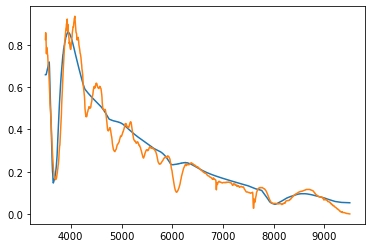

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
# 使用最佳模型进行预测
# param_pred = np.random.rand(10)
# X_pred = np.poly1d(param_pred)(x)
X_pred=spec_data[:,1]*0.4
y_pred = best_model.predict(X_pred.reshape(1,-1))
# print(param_pred)
print(y_pred)

syn_id=0
yaml_file=spec_base+"."+str(syn_id).zfill(zfill)+".yaml"
pred_yaml_name=spec_base+".pred.yaml"

replace_pred_param(yaml_file,pred_yaml_name,y_pred)
synpp_result=invoke_synpp(pred_yaml_name)
# calculate_chi2(spec_data,synpp_result,spec_range)
plt.plot(synpp_result[:,0],synpp_result[:,1])
plt.plot(synpp_result[:,0],X_pred[:])


# 计算均方误差
# mse = mean_squared_error(param_pred, 
#                             y_pred[0])
# print("均方误差：", mse)
# plt.plot(X,y_pred)

# import matplotlib.pyplot as plt
# plt.plot(param_pred,y_pred[0],".")
# plt.plot([0,1],[0,1])

# plt.figure()
# plt.plot(range(10),param_pred,".")
# plt.plot(range(10),y_pred[0],".")


# plt.figure()
# plt.plot(x,X_pred)
# plt.plot(x,np.poly1d(y_pred[0])(x))

In [ ]:
print(11d)

SyntaxError: invalid syntax (<ipython-input-30-6ed0784b0638>, line 1)

In [ ]:
import yaml
spec_base="SN2011fe_110906"
synpp_yaml_name_tmp=spec_base+"_syn++.0000.tmp.bb.yaml"


with open(synpp_yaml_name_tmp,"w") as f:
    print  (Synpp.create(),file=f)
param_synpp=yaml.safe_load(open(synpp_yaml_name_tmp))
param_synpp["opacity"]['line_dir']="/usr/local/share/es/lines"
param_synpp["opacity"]['ref_file']="/usr/local/share/es/refs.dat"
with open(synpp_yaml_name_tmp,"w") as f:
    print  (Synpp.create(param_synpp),file=f)    